<h1 align="center">Spatial Data with Python Workshop</h1>

<h4 align="center"><i>Created by <a href="https://github.com/amitparikh1">Amit Parikh</a> for Carolina Analytics and Data Science on 3/1/2023</i></h4>

 
**Spatial Data** can be defined as any series of data that has an implicit or explicit association with a geographic location. Spatial data is all around us and is constantly being collected. 

In this workshop we will go over some common examples of spatial datasets, data types that are specific to spatial data, how to best analyze spatial data in Python using GeoPandas, and explore ways we can visualize spatial data. 

This workshop is meant to be **introductory** and is open to all skill levels. A basic understanding of Python and Pandas would be helpful, but not necessary. To familiarize yourself with Python and Pandas, check out our <a href="https://youtube.com/playlist?list=PLtOYSqZWWG7L1tUaEgUwtJP0d9xYHN7o1"> CADS intro YouTube series </a>. 

## Examples of Spatial Data

## Data Types Specific to Spatial Data <a href="https://www.safe.com/what-is/spatial-data/">(Source)</a>

### Vector

Vector data is the most commmon type of spatial data. Data in this form comes in three types: **point**, **lines**, and **polygons**.

<img src="https://datacarpentry.org/organization-geospatial/fig/dc-spatial-vector/pnt_line_poly.png" width =250/>

**Points** are represented by a ***(latitude, longitude)*** coordinate pair that corresponds to a physical location in the world. 

    Example: the precise location of a thermometer recording daily temperatures.

**Lines** are represented by ***2+*** points that are ***connected together***. Each "bend" in a line is represented by a new point. 

    Example: a line can be used to mark a GPS route from point A to point B. 
    
**Polygons** are represented by ***3+*** points that are ***connected together*** and ***closed***. 

    Example: a polygon can mark the boundary of a county, zipcode, state, or country. 
<img src="https://digital.newberry.org/ahcb/images/statepages/North_Carolina.gif" width =250/>

### Raster

Raster data is gridded data where each pixel is associated with a specific geographical location.

    Example: commonly used to represent satellite image data. 
    
<img src="https://datacarpentry.org/organization-geospatial/fig/dc-spatial-raster/raster_concept.png" width =250/>

### Attributes

Attributes refer to additional data that describes a geographical feature. 

    Example: A polygon that represents a home has attributes such as # of bedrooms, # of bathrooms, square footage etc. 

### Geocoding

The process by which tabular data such as address is analyzed and converted into latitude, longitude coordinates. 

    Example: Say a Real Estate investor had the street addresses of 100 homes in his portfolio! To visualize where these homes are on a map, you would first geocode the addresses to lat, lng coordinates. 
    
Many API services offer free tiers for geocoding such as <a href="https://developers.google.com/maps">Google Maps </a> and <a href= "https://developer.here.com/"> HERE </a>.

## Using GeoPandas to Analyze Spatial Data

GeoPandas is a library that extends Pandas to work more nicely with spatial data. 

### Get GeoPandas setup

In [42]:
# Installations
# !pip install geopandas   ---> If you don't have geopandas installed, uncomment this line

In [43]:
# Imports
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

### Read in the data

In [44]:
# Use a provided sample dataset given by GeoPandas
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_world.head(10)

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
5,18513930.0,Asia,Kazakhstan,KAZ,181665,"POLYGON ((87.35997 49.21498, 86.59878 48.54918..."
6,33580650.0,Asia,Uzbekistan,UZB,57921,"POLYGON ((55.96819 41.30864, 55.92892 44.99586..."
7,8776109.0,Oceania,Papua New Guinea,PNG,24829,"MULTIPOLYGON (((141.00021 -2.60015, 142.73525 ..."
8,270625568.0,Asia,Indonesia,IDN,1119190,"MULTIPOLYGON (((141.00021 -2.60015, 141.01706 ..."
9,44938712.0,South America,Argentina,ARG,445445,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."


### Take a look at the data

In [45]:
# What are the data types in each column
df_world.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 177 entries, 0 to 176
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   pop_est     177 non-null    float64 
 1   continent   177 non-null    object  
 2   name        177 non-null    object  
 3   iso_a3      177 non-null    object  
 4   gdp_md_est  177 non-null    int64   
 5   geometry    177 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 8.4+ KB


In [46]:
# How is the geometry column stored
print(type(df_world['geometry']))

<class 'geopandas.geoseries.GeoSeries'>


The geometry column has a special **geometry** data type and is stored as a **geoseries**.

The 3 basic classes of geometric objects are:

    - Points / Multi-Points
    - Lines / Multi-Lines
    - Polygons / Multi-Polygons

Geoseries have special attributes that may be useful in spatial analysis:

    * Area
    * Centroid 
    * geom_type
and so much more...

Let's look at **centroid** for example.

In [47]:
# Centroid (returns a Point that is at the center of the geometry)
print(df_world['geometry'].centroid)

0      POINT (163.85316 -17.31631)
1        POINT (34.75299 -6.25773)
2       POINT (-12.13783 24.29117)
3       POINT (-98.14238 61.46908)
4      POINT (-112.59944 45.70563)
                  ...             
172      POINT (20.81965 44.23304)
173      POINT (19.28618 42.78904)
174      POINT (20.89536 42.57937)
175     POINT (-61.33037 10.42824)
176       POINT (30.19862 7.29289)
Length: 177, dtype: geometry


C:\Users\Amit\AppData\Local\Temp\ipykernel_18132\3704249613.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  print(df_world['geometry'].centroid)


C:\Users\Amit\AppData\Local\Temp\ipykernel_18132\3448864836.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  indonesia.centroid.plot(ax=base_indonesia, color='r', figsize=(10,10))


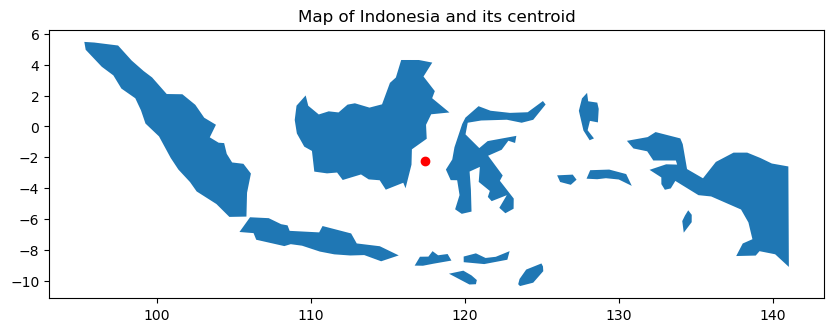

In [60]:
# Note: Centroid of a Multi-Polygon may not be inside any of the sub-polygons
indonesia = df_world[df_world['name'] == 'Indonesia']
base_indonesia = indonesia.plot(figsize=(10,10))
indonesia.centroid.plot(ax=base_indonesia, color='r', figsize=(10,10))
plt.title("Map of Indonesia and its centroid")
plt.show()

### Aggregation with dissolve <a href="https://geopandas.org/en/stable/docs/user_guide/aggregation_with_dissolve.html">(GeoPandas Docs)</a>

Right now we can plot Population (or other metrics) on the country level

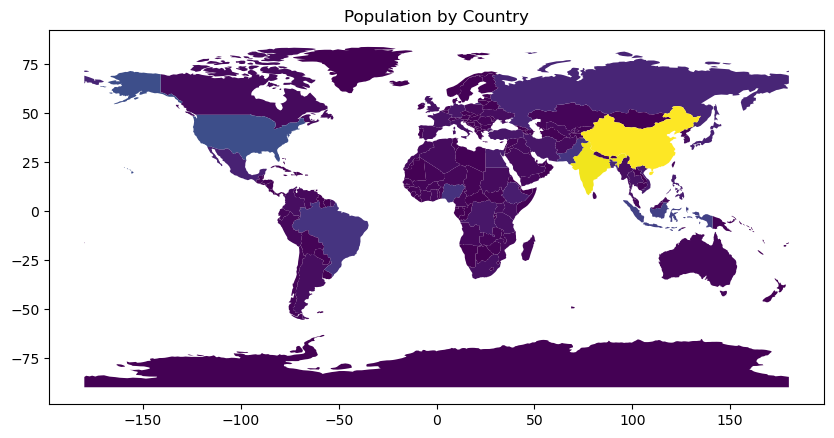

In [58]:
df_world.plot('pop_est', figsize=(10,10))
plt.title("Population by Country")
plt.show()

What if we want to look at the data on the continent level?

In [50]:
# 8 continents is much less granular and more manageable
num_continents = df_world['continent'].nunique()
print(f'We have {num_continents} different continents.')

# Dissolve allows us to aggregate geometric features (for non-geometric features it performs a Pandas GroupBy)
df_continent = df_world.dissolve('continent', aggfunc='sum').reset_index()
df_continent

We have 8 different continents.


C:\Users\Amit\anaconda3\lib\site-packages\geopandas\geodataframe.py:1676: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  aggregated_data = data.groupby(**groupby_kwargs).agg(aggfunc)


,continent,geometry,pop_est,gdp_md_est
0,Africa,"MULTIPOLYGON (((32.83012 -26.74219, 32.58026 -...",1.306370e+09,2455514
1,Antarctica,"MULTIPOLYGON (((-163.71290 -78.59567, -163.712...",4.490000e+03,898
2,Asia,"MULTIPOLYGON (((120.29501 -10.25865, 118.96781...",4.550277e+09,32725478
3,Europe,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3...",7.454125e+08,21587850
4,North America,"MULTIPOLYGON (((-61.68000 10.76000, -61.10500 ...",5.837560e+08,25075988
5,Oceania,"MULTIPOLYGON (((169.66781 -43.55533, 170.52492...",4.120487e+07,1647113
6,Seven seas (open ocean),"POLYGON ((68.93500 -48.62500, 69.58000 -48.940...",1.400000e+02,16
7,South America,"MULTIPOLYGON (((-66.95992 -54.89681, -67.29103...",4.270667e+08,3852015


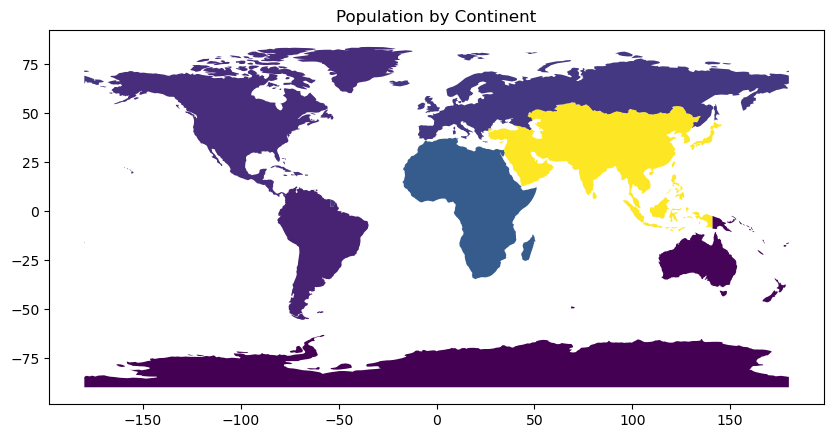

In [59]:
# Plot the new DataFrame
df_continent.plot('pop_est', figsize=(10,10))
plt.title("Population by Continent")
plt.show()

This concept can be applied to geographies of all granularities. For example aggregating and disolving:

    * county level to state level
    * state level to country level
    
**any smaller geography can be aggregated up to a larger county level**, but not the other way around. 

### Spatial Joins

Spatial joins consist of two types. 

**Binary predicate joins** (uses the function *GeoDataFrame.sjoin()*):
    
    * intersect
    * contains 
    * within
    * touches
    * crosses 
    * overlaps
    
and **nearest joins** (uses the function *GeoDataFrame.sjoin_nearest()*): based on proximity between the geometries being merged.

Let's practice spatial joins by joining cities to countries based on their geometry. If a city is within a country, we will match them up! This will use a **binary predicate join**. 

In [52]:
# Read in a new data frame for cities that we will use for joining
df_cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
df_cities.head()

,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Lobamba,POINT (31.20000 -26.46667)
4,Luxembourg,POINT (6.13000 49.61166)


In [53]:
# Focus on the countries and geometries in df_world
df_countries = df_world[['name', 'geometry']]
df_countries = df_countries.rename(columns={'name': 'country'})

In [54]:
df_cities_and_countries = df_cities.sjoin(df_countries, predicate = 'within')
df_cities_and_countries.sample(10)

,name,geometry,index_right,country
106,Nur-Sultan,POINT (71.42777 51.18113),5,Kazakhstan
239,São Paulo,POINT (-46.62697 -23.55673),29,Brazil
103,Bamako,POINT (-8.00198 12.65196),52,Mali
190,Dakar,POINT (-17.47508 14.71778),51,Senegal
182,Kyiv,POINT (30.51468 50.43531),112,Ukraine
121,Phnom Penh,POINT (104.91469 11.55198),90,Cambodia
80,Abuja,POINT (7.48951 9.05462),56,Nigeria
206,Addis Ababa,POINT (38.69806 9.03526),165,Ethiopia
158,Kuala Lumpur,POINT (101.68870 3.13980),148,Malaysia
16,Mbabane,POINT (31.13333 -26.31665),73,eSwatini


Notice the index_right column. We won't dive into this but I recommend reading about spatial indexes <a href="https://learn.microsoft.com/en-us/sql/relational-databases/spatial/spatial-indexes-overview?view=sql-server-ver16"> here </a>.

### Interactive Mapping

Geopandas can make interactive maps based on the folium library. 

In [55]:
# The simplest option using the GeoDataFrame.explore() function
df_world.explore()

In [56]:
# Let's add some customization
df_world.explore(
     column="continent", # make choropleth based on "BoroName" column
     tooltip="name", # show "BoroName" value in tooltip (on hover)
     tiles="CartoDB positron", # use "CartoDB positron" tiles
     cmap="Set1", # use "Set1" matplotlib colormap
     style_kwds=dict(color="black"), # use black outline
    )

In [57]:
# Adding multiple tiles
cont = df_world.explore(
     column="continent", # make choropleth based on "BoroName" column
     tooltip="name", # show "BoroName" value in tooltip (on hover)
     tiles="CartoDB positron", # use "CartoDB positron" tiles
     cmap="Set1", # use "Set1" matplotlib colormap
     style_kwds=dict(color="black"), # use black outline
     name="countries",
     max_bounds=True,
    )

df_cities.explore(
     m=cont, # pass the map object
     color="red", # use red color on all points
     tooltip="name", # show "name" column in the tooltip
     tooltip_kwds=dict(labels=False), # do not show column label in the tooltip
     name="cities", # name of the layer in the map
     max_bounds=True,
)

folium.TileLayer('Stamen Toner', control=True).add_to(cont)  # use folium to add alternative tiles
folium.LayerControl().add_to(cont)  # use folium to add layer control

cont  # show map

Try playing around with this on your own time and merging in other interesting spatial data.

## Thanks for coming and any questions?